In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Input, Multiply, Activation
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM10_aeroequal_and_council.csv')
data.head()

,Datetime,PM10_mg/m³_aeroequal,PM10_µg/m³_council
0,2024-08-15 15:00:00,1.983333,17.0
1,2024-08-15 16:00:00,2.800000,14.8
2,2024-08-15 17:00:00,1.100000,18.1
3,2024-08-15 18:00:00,1.250000,14.4
4,2024-08-16 12:00:00,0.816667,12.5


In [3]:
X = data[['PM10_mg/m³_aeroequal']].values
y = data['PM10_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[0.53333333],
       [1.98333333],
       [0.81666667],
       [1.13333333],
       [8.09090909]])

array([[-0.78989773],
       [-0.17158621],
       [-0.66907824],
       [-0.53404469],
       [ 2.43281684]])

array([[1.11764706],
       [4.625     ],
       [2.2       ],
       [1.03333333],
       [1.48333333]])

array([[-0.54073366],
       [ 0.95487787],
       [-0.07919484],
       [-0.57668686],
       [-0.38479708]])

In [7]:
def build_keras_model(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
def build_rnn_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(SimpleRNN(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [9]:
def build_gru_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(GRU(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
def build_lstm_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(LSTM(units[i], return_sequences=False))
    
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [11]:
def build_keras_model_with_attention(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    
    attention = Dense(1, activation='tanh')(model.layers[-1].output)
    attention = Activation('softmax')(attention)
    attention = Multiply()([model.layers[-1].output, attention])
    
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
def build_rnn_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    rnn_out = inputs
    for i in range(layers):
        rnn_out = SimpleRNN(units[i], return_sequences=True if layers > 1 else False)(rnn_out)
    
    attention = Dense(1, activation='tanh')(rnn_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([rnn_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
def build_gru_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    gru_out = inputs
    for i in range(layers):
        gru_out = GRU(units[i], return_sequences=True if layers > 1 else False)(gru_out)
    
    attention = Dense(1, activation='tanh')(gru_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([gru_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
def build_lstm_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    lstm_out = inputs
    
    for i in range(layers):
        lstm_out = LSTM(units[i], return_sequences=True if layers > 1 else False)(lstm_out)
    
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([lstm_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## Experimented List of Models and Parameters

#### The MLPRegressor: This model optimizes the squared error using LBFGS or stochastic gradient descent.
#### The KerasRegressor: Wrapper that enables Keras models so that they can be used as part of a Scikit-Learn workflow

In [15]:
models = {
    'MLP Regressor': MLPRegressor(random_state=42, verbose=0),
    'Keras Regressor': KerasRegressor(build_fn=build_keras_model, verbose=0),
    'RNN Regressor': KerasRegressor(build_fn=build_rnn_model, verbose=0),
    'GRU Regressor': KerasRegressor(build_fn=build_gru_model, verbose=0),
    'LSTM Regressor': KerasRegressor(build_fn=build_lstm_model, verbose=0),
    'MLP Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'Keras Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'RNN Regressor with Attention': KerasRegressor(build_fn=build_rnn_model_with_attention, verbose=0),
    'GRU Regressor with Attention': KerasRegressor(build_fn=build_gru_model_with_attention, verbose=0),
    'LSTM Regressor with Attention': KerasRegressor(build_fn=build_lstm_model_with_attention, verbose=0),
}

params = {
    'MLP Regressor': {
        'hidden_layer_sizes': [(50, 50), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400],
    },
    'Keras Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'MLP Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'Keras Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    }
}

#### 1. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 2. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [16]:
best_models = []

best_score = float('inf')
best_params = None
best_model_name = ''

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train_scaled, y_train)
    
    try:
        best_models.append({
            'name': model_name,
            'model': grid_result.best_estimator_,
            'params': grid_result.best_params_,
            'rmse': -grid_result.best_score_
        })
    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training MLP Regressor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Keras Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training MLP Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Keras Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### For showcasing model with the best R2

In [17]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled) 
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

In [18]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: RNN Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'rmsprop'}
Test RMSE: 2.2087
Test MSE: 4.8782
Test R2: 0.6428
Test MAE: 1.9492


,Actual,Predicted
0,14.0,11.849993
1,21.1,18.614403
2,16.1,14.219364
3,13.4,11.655252
4,12.9,12.678050
5,9.7,12.529132
6,18.1,16.519508
7,20.6,16.996046
8,18.9,18.808451
9,11.2,12.936425


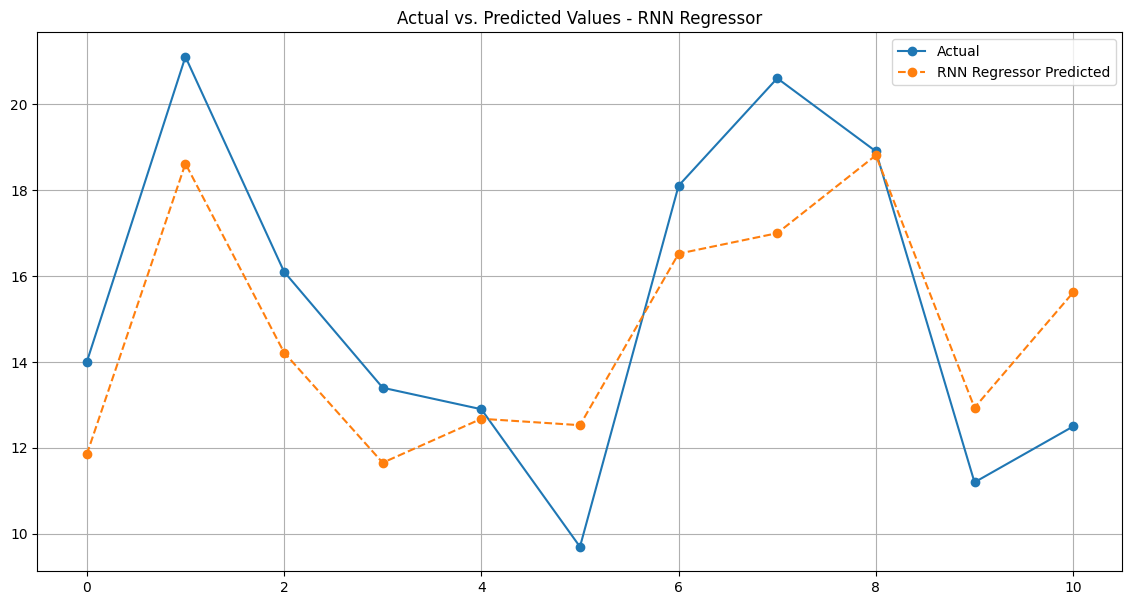


Results For Model: GRU Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 2.4759
Test MSE: 6.1299
Test R2: 0.5512
Test MAE: 2.2288


,Actual,Predicted
0,14.0,11.897830
1,21.1,17.682127
2,16.1,13.650789
3,13.4,11.763959
4,12.9,12.483418
5,9.7,12.376090
6,18.1,15.614134
7,20.6,16.059164
8,18.9,17.888973
9,11.2,12.671811


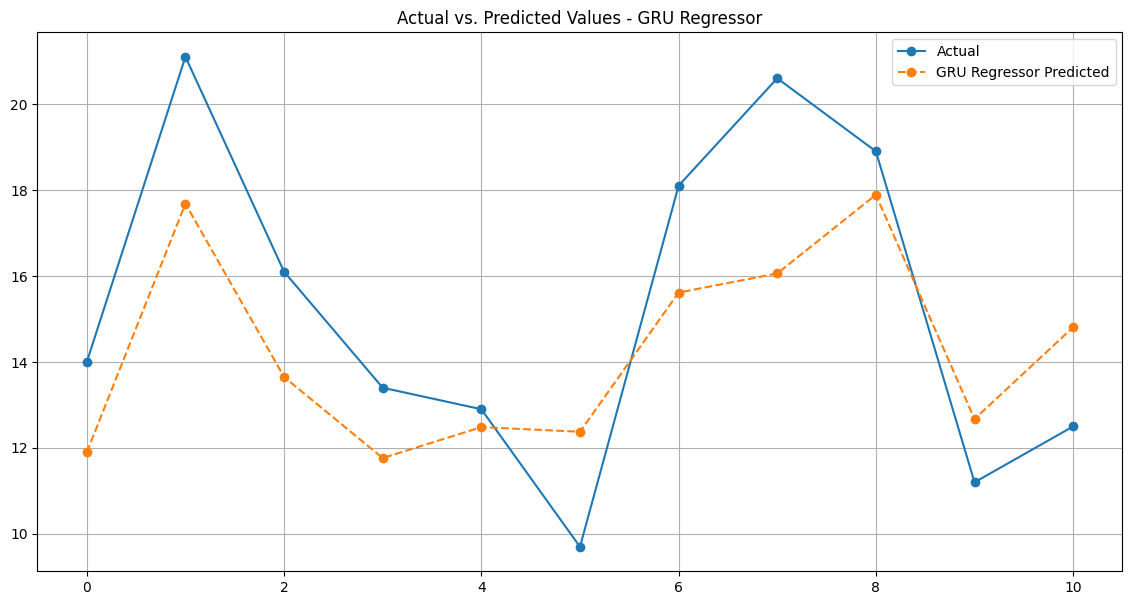


Results For Model: LSTM Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 2.7357
Test MSE: 7.4839
Test R2: 0.4520
Test MAE: 2.4171


,Actual,Predicted
0,14.0,12.050751
1,21.1,16.964537
2,16.1,13.376931
3,13.4,11.955661
4,12.9,12.477164
5,9.7,12.397746
6,18.1,15.033849
7,20.6,15.433621
8,18.9,17.167713
9,11.2,12.617930


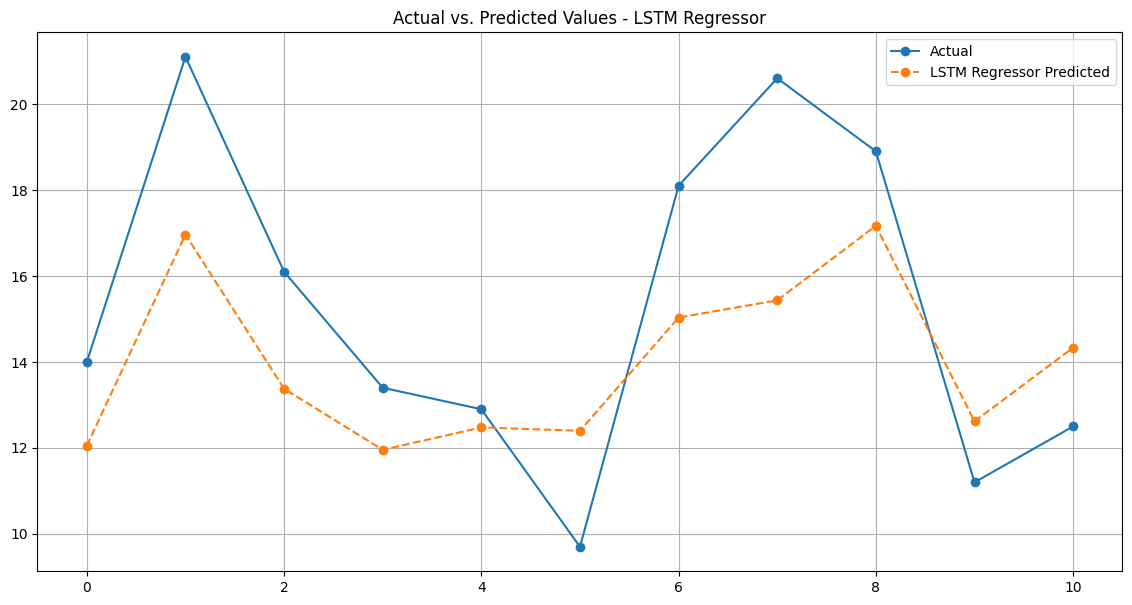


Results For Model: MLP Regressor
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'sgd'}
Test RMSE: 2.9233
Test MSE: 8.5458
Test R2: 0.3743
Test MAE: 2.5153


,Actual,Predicted
0,14.0,12.300516
1,21.1,16.518165
2,16.1,13.242480
3,13.4,12.231081
4,12.9,12.604616
5,9.7,12.548685
6,18.1,14.624239
7,20.6,15.024358
8,18.9,16.712127
9,11.2,12.702599


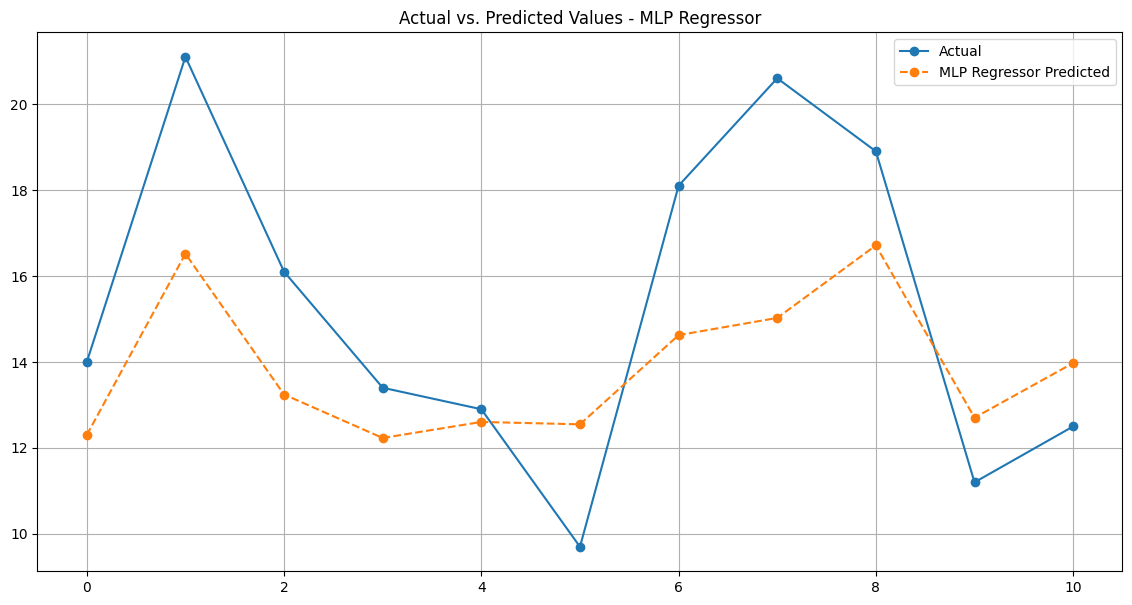


Results For Model: RNN Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 3.6773
Test MSE: 13.5225
Test R2: 0.0099
Test MAE: 3.0059


,Actual,Predicted
0,14.0,13.663589
1,21.1,14.467578
2,16.1,14.040222
3,13.4,13.628406
4,12.9,13.806047
5,9.7,13.781281
6,18.1,14.311502
7,20.6,14.355130
8,18.9,14.477141
9,11.2,13.848127


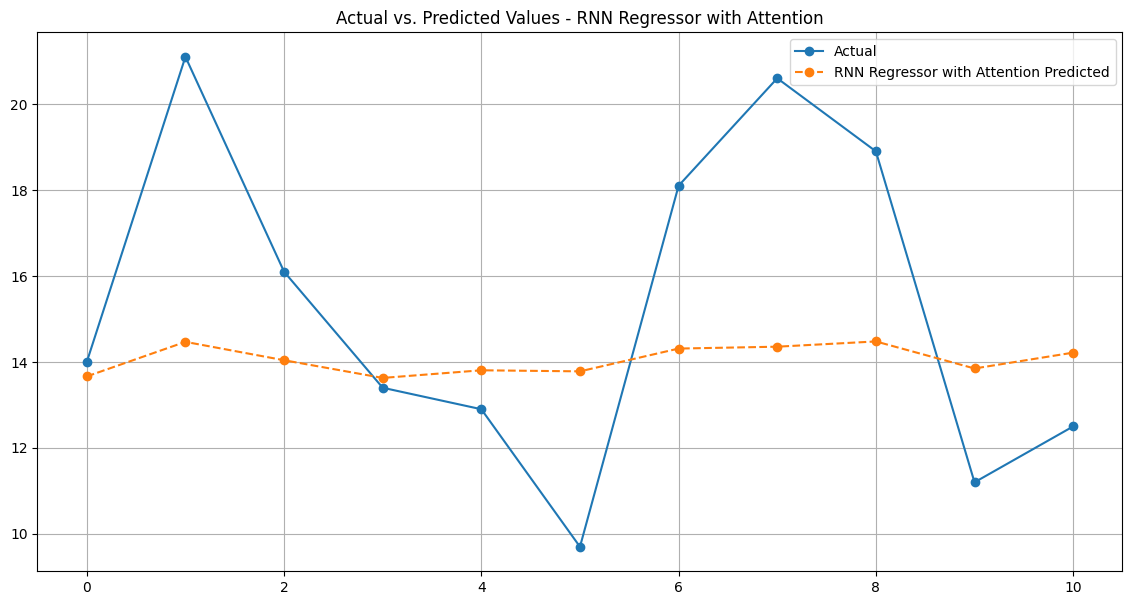


Results For Model: GRU Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 3.8209
Test MSE: 14.5989
Test R2: -0.0689
Test MAE: 3.1048


,Actual,Predicted
0,14.0,13.819348
1,21.1,14.212347
2,16.1,13.910475
3,13.4,13.813416
4,12.9,13.847038
5,9.7,13.841753
6,18.1,14.041390
7,20.6,14.075279
8,18.9,14.231359
9,11.2,13.856539


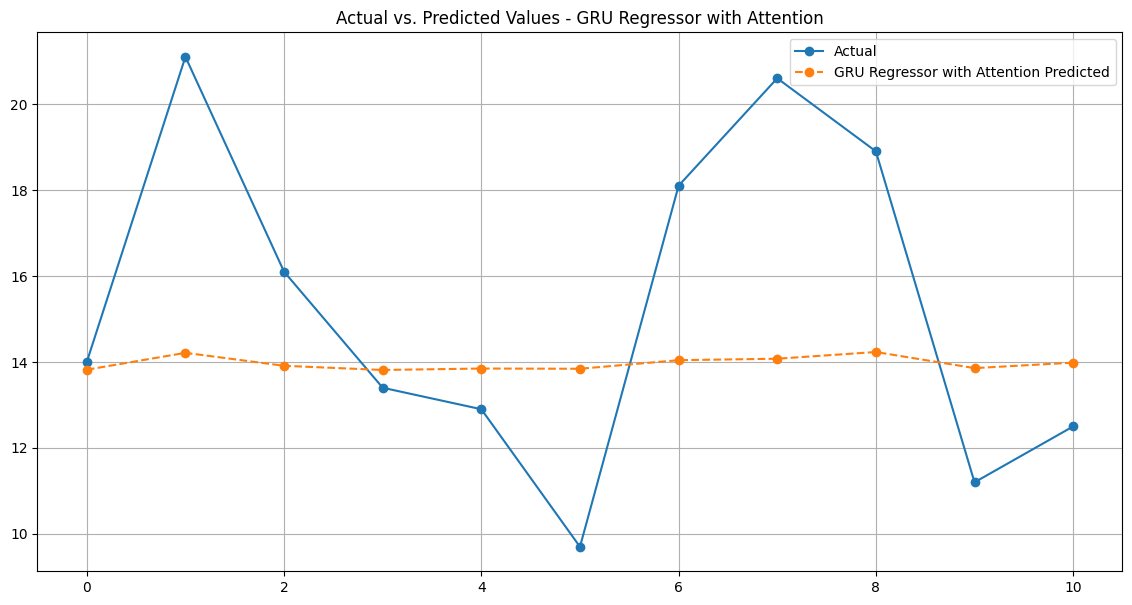


Results For Model: LSTM Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 4.3821
Test MSE: 19.2030
Test R2: -0.4060
Test MAE: 3.4388


,Actual,Predicted
0,14.0,13.932758
1,21.1,13.062712
2,16.1,13.470669
3,13.4,13.972503
4,12.9,13.765446
5,9.7,13.795258
6,18.1,13.133240
7,20.6,13.091011
8,18.9,13.074036
9,11.2,13.714120


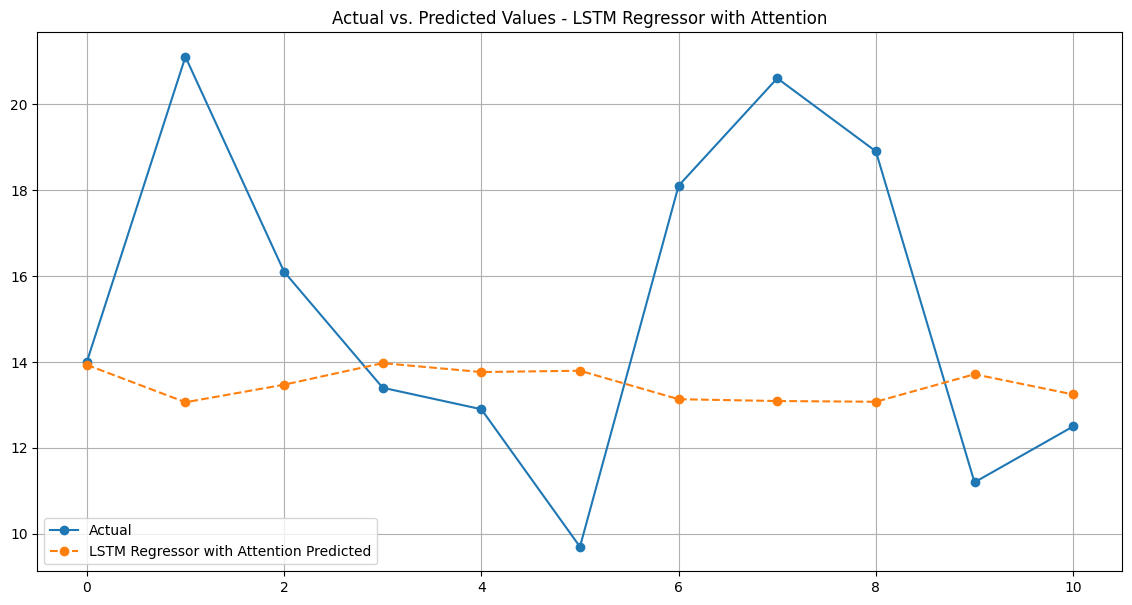


Results For Model: MLP Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 5.0403
Test MSE: 25.4045
Test R2: -0.8601
Test MAE: 4.0383


,Actual,Predicted
0,14.0,12.421643
1,21.1,13.585485
2,16.1,9.793544
3,13.4,12.754837
4,12.9,11.101847
5,9.7,11.342395
6,18.1,10.696093
7,20.6,11.288660
8,18.9,13.885166
9,11.2,10.728995


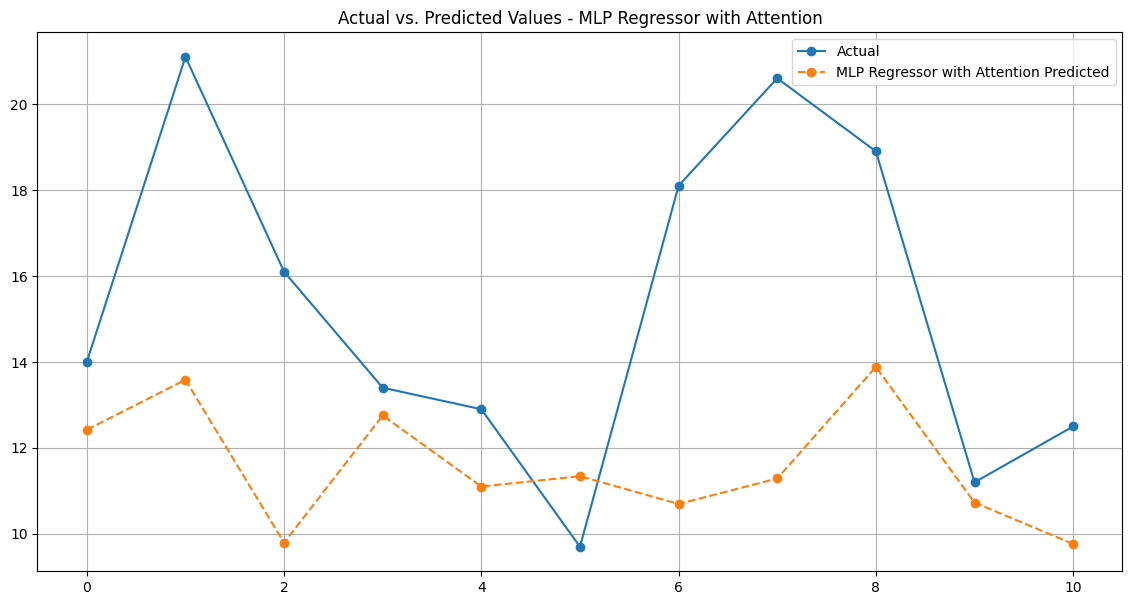


Results For Model: Keras Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 5.8301
Test MSE: 33.9901
Test R2: -1.4887
Test MAE: 4.5982


,Actual,Predicted
0,14.0,12.593577
1,21.1,12.171181
2,16.1,9.270255
3,13.4,12.943638
4,12.9,11.148337
5,9.7,11.387900
6,18.1,9.517493
7,20.6,9.994622
8,18.9,12.478154
9,11.2,10.729101


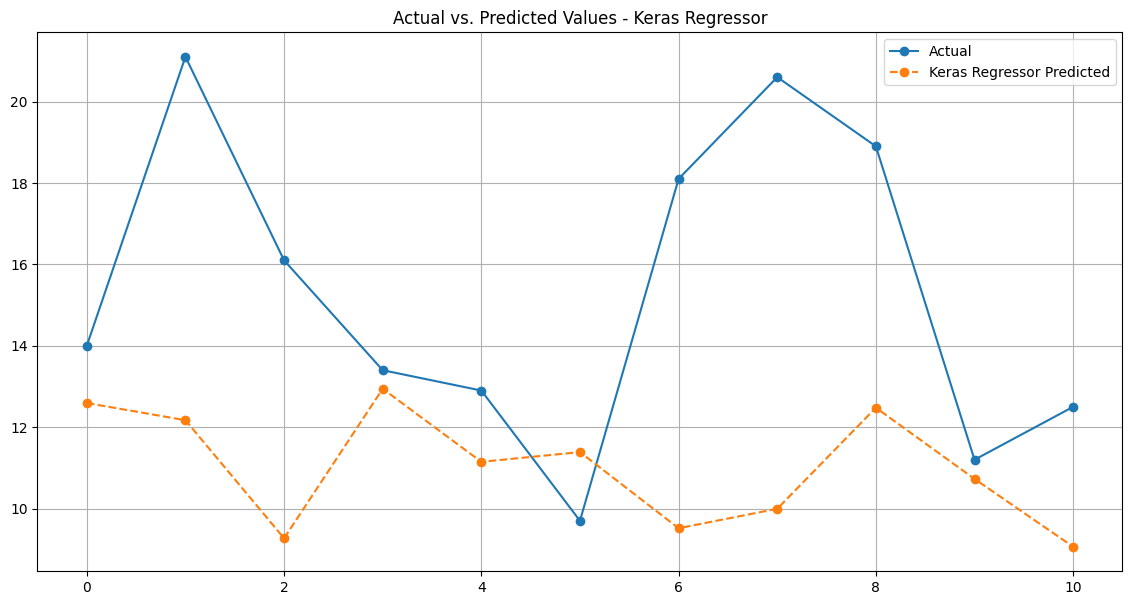


Results For Model: Keras Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 6.2684
Test MSE: 39.2930
Test R2: -1.8770
Test MAE: 4.9844


,Actual,Predicted
0,14.0,12.504387
1,21.1,11.809805
2,16.1,8.736421
3,13.4,12.871197
4,12.9,10.977809
5,9.7,11.241646
6,18.1,8.710175
7,20.6,9.273268
8,18.9,12.145072
9,11.2,10.518242


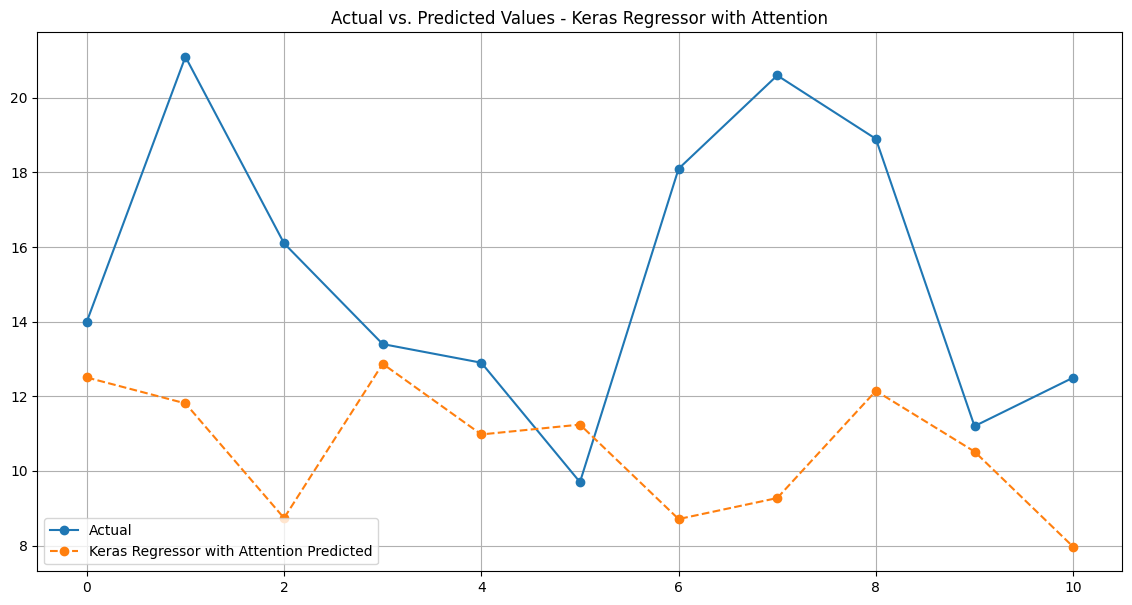

In [19]:
for result in results:
    model_name = result['name']
    print(f"Results For Model: {model_name}")
    print(f"Best Hyperparameters: {result['params']}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print(f"Test MSE: {result['mse']:.4f}")
    print(f"Test R2: {result['r2']:.4f}")
    print(f"Test MAE: {result['mae']:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [20]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,RNN Regressor,2.208667,4.878208,0.642828,1.949222
1,GRU Regressor,2.475869,6.129927,0.551179,2.228761
2,LSTM Regressor,2.735678,7.483936,0.452041,2.417128
3,MLP Regressor,2.923328,8.545844,0.374291,2.515332
4,RNN Regressor with Attention,3.677292,13.522478,0.009912,3.005945
5,GRU Regressor with Attention,3.820857,14.598945,-0.068905,3.104780
6,LSTM Regressor with Attention,4.382125,19.203018,-0.406006,3.438784
7,MLP Regressor with Attention,5.040284,25.404467,-0.860063,4.038318
8,Keras Regressor,5.830101,33.990073,-1.488684,4.598177
9,Keras Regressor with Attention,6.268415,39.293030,-1.876955,4.984385
